### Plot grit scores for Spheroid Aggregated data

In [81]:
import pandas as pd
import numpy as np
import os

# Grit scores
from cytominer_eval import evaluate

# Plotting
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set_style("white")


# Set current working directory
print(os.getcwd())
os.chdir('/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1')
print(os.getcwd())

/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1
/share/data/analyses/christa/colopaint3D_fork/spher_colo52_v1


In [82]:
# Set up the plotting parameters
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
dpi = 300
figformat = 'pdf'

In [83]:
cell_line = 'HCT116'
data_type = '2D'

In [84]:
# Load the data
dir = '1_Data/results/'
data =  pd.read_parquet(('{}selected_data_{}_{}.parquet').format(dir, data_type, cell_line))

In [85]:
# Some function definitions

def list_features(df):
    # List features
    list_of_selected_features = list(df.columns.values)
    list_of_metadata = list(df.columns[df.columns.str.contains("Metadata_")])
    list_of_selected_features = list(set(list_of_selected_features) - set(list_of_metadata))
    
    return list_of_selected_features, list_of_metadata

### Grit

In [86]:
## Prepare the metadata for the grit calculation
dataset_grit = data.copy()

dataset_grit['Metadata_name'] = dataset_grit['Metadata_cmpdname'].str[:5] 

# Add a column with the step of the concentration (easier for plotting)
dataset_grit['Metadata_conc_step'] = (
    dataset_grit.groupby('Metadata_cmpdname')['Metadata_cmpd_conc'].rank(ascending=True, method='dense')
    )
# Add a column with the name of the perturbation (compound + concentration)
dataset_grit["Metadata_pert_name"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit["Metadata_cmpd_conc"].astype(str)
    )
# Add a column with the a unique identifier for each replicate
dataset_grit["Metadata_replicate_id"] = (
    dataset_grit["Metadata_name"] + "_" + dataset_grit.index.astype(str)
    )

In [87]:
# Setup the data for calculating grit

# Set up the input for evaluate
control_perts = dataset_grit.query("Metadata_name == 'dmso' & Metadata_cmpd_conc == 0.1").Metadata_replicate_id.unique().tolist()
grit_replicate_groups = {"profile_col": "Metadata_replicate_id", "replicate_group_col": "Metadata_pert_name"} 

In [88]:
# Calcuate the grit scores

grit_scores = []

grit_results = evaluate(
    profiles=dataset_grit,
    features=list_features(dataset_grit)[0],
    meta_features=list_features(dataset_grit)[1],
    replicate_groups=grit_replicate_groups,
    operation="grit",
    similarity_metric="pearson",
    grit_replicate_summary_method="median",
    grit_control_perts=control_perts,
)

grit_scores.append(grit_results)

In [89]:
# Organize the grit scores

grit_scores = pd.concat(grit_scores).reset_index(drop=True)
grit_scores["Metadata_name"] = grit_scores["perturbation"].str.split("_").str[0]

# Add back the well information
grit_scores = pd.merge(grit_scores,dataset_grit[['Metadata_PlateWell', 'Metadata_replicate_id','Metadata_cmpd_conc', 'Metadata_conc_step', 'Metadata_pert_type']], left_on='perturbation', right_on='Metadata_replicate_id')

# list the compounds
CompoundsUsed = grit_scores["Metadata_name"].unique()

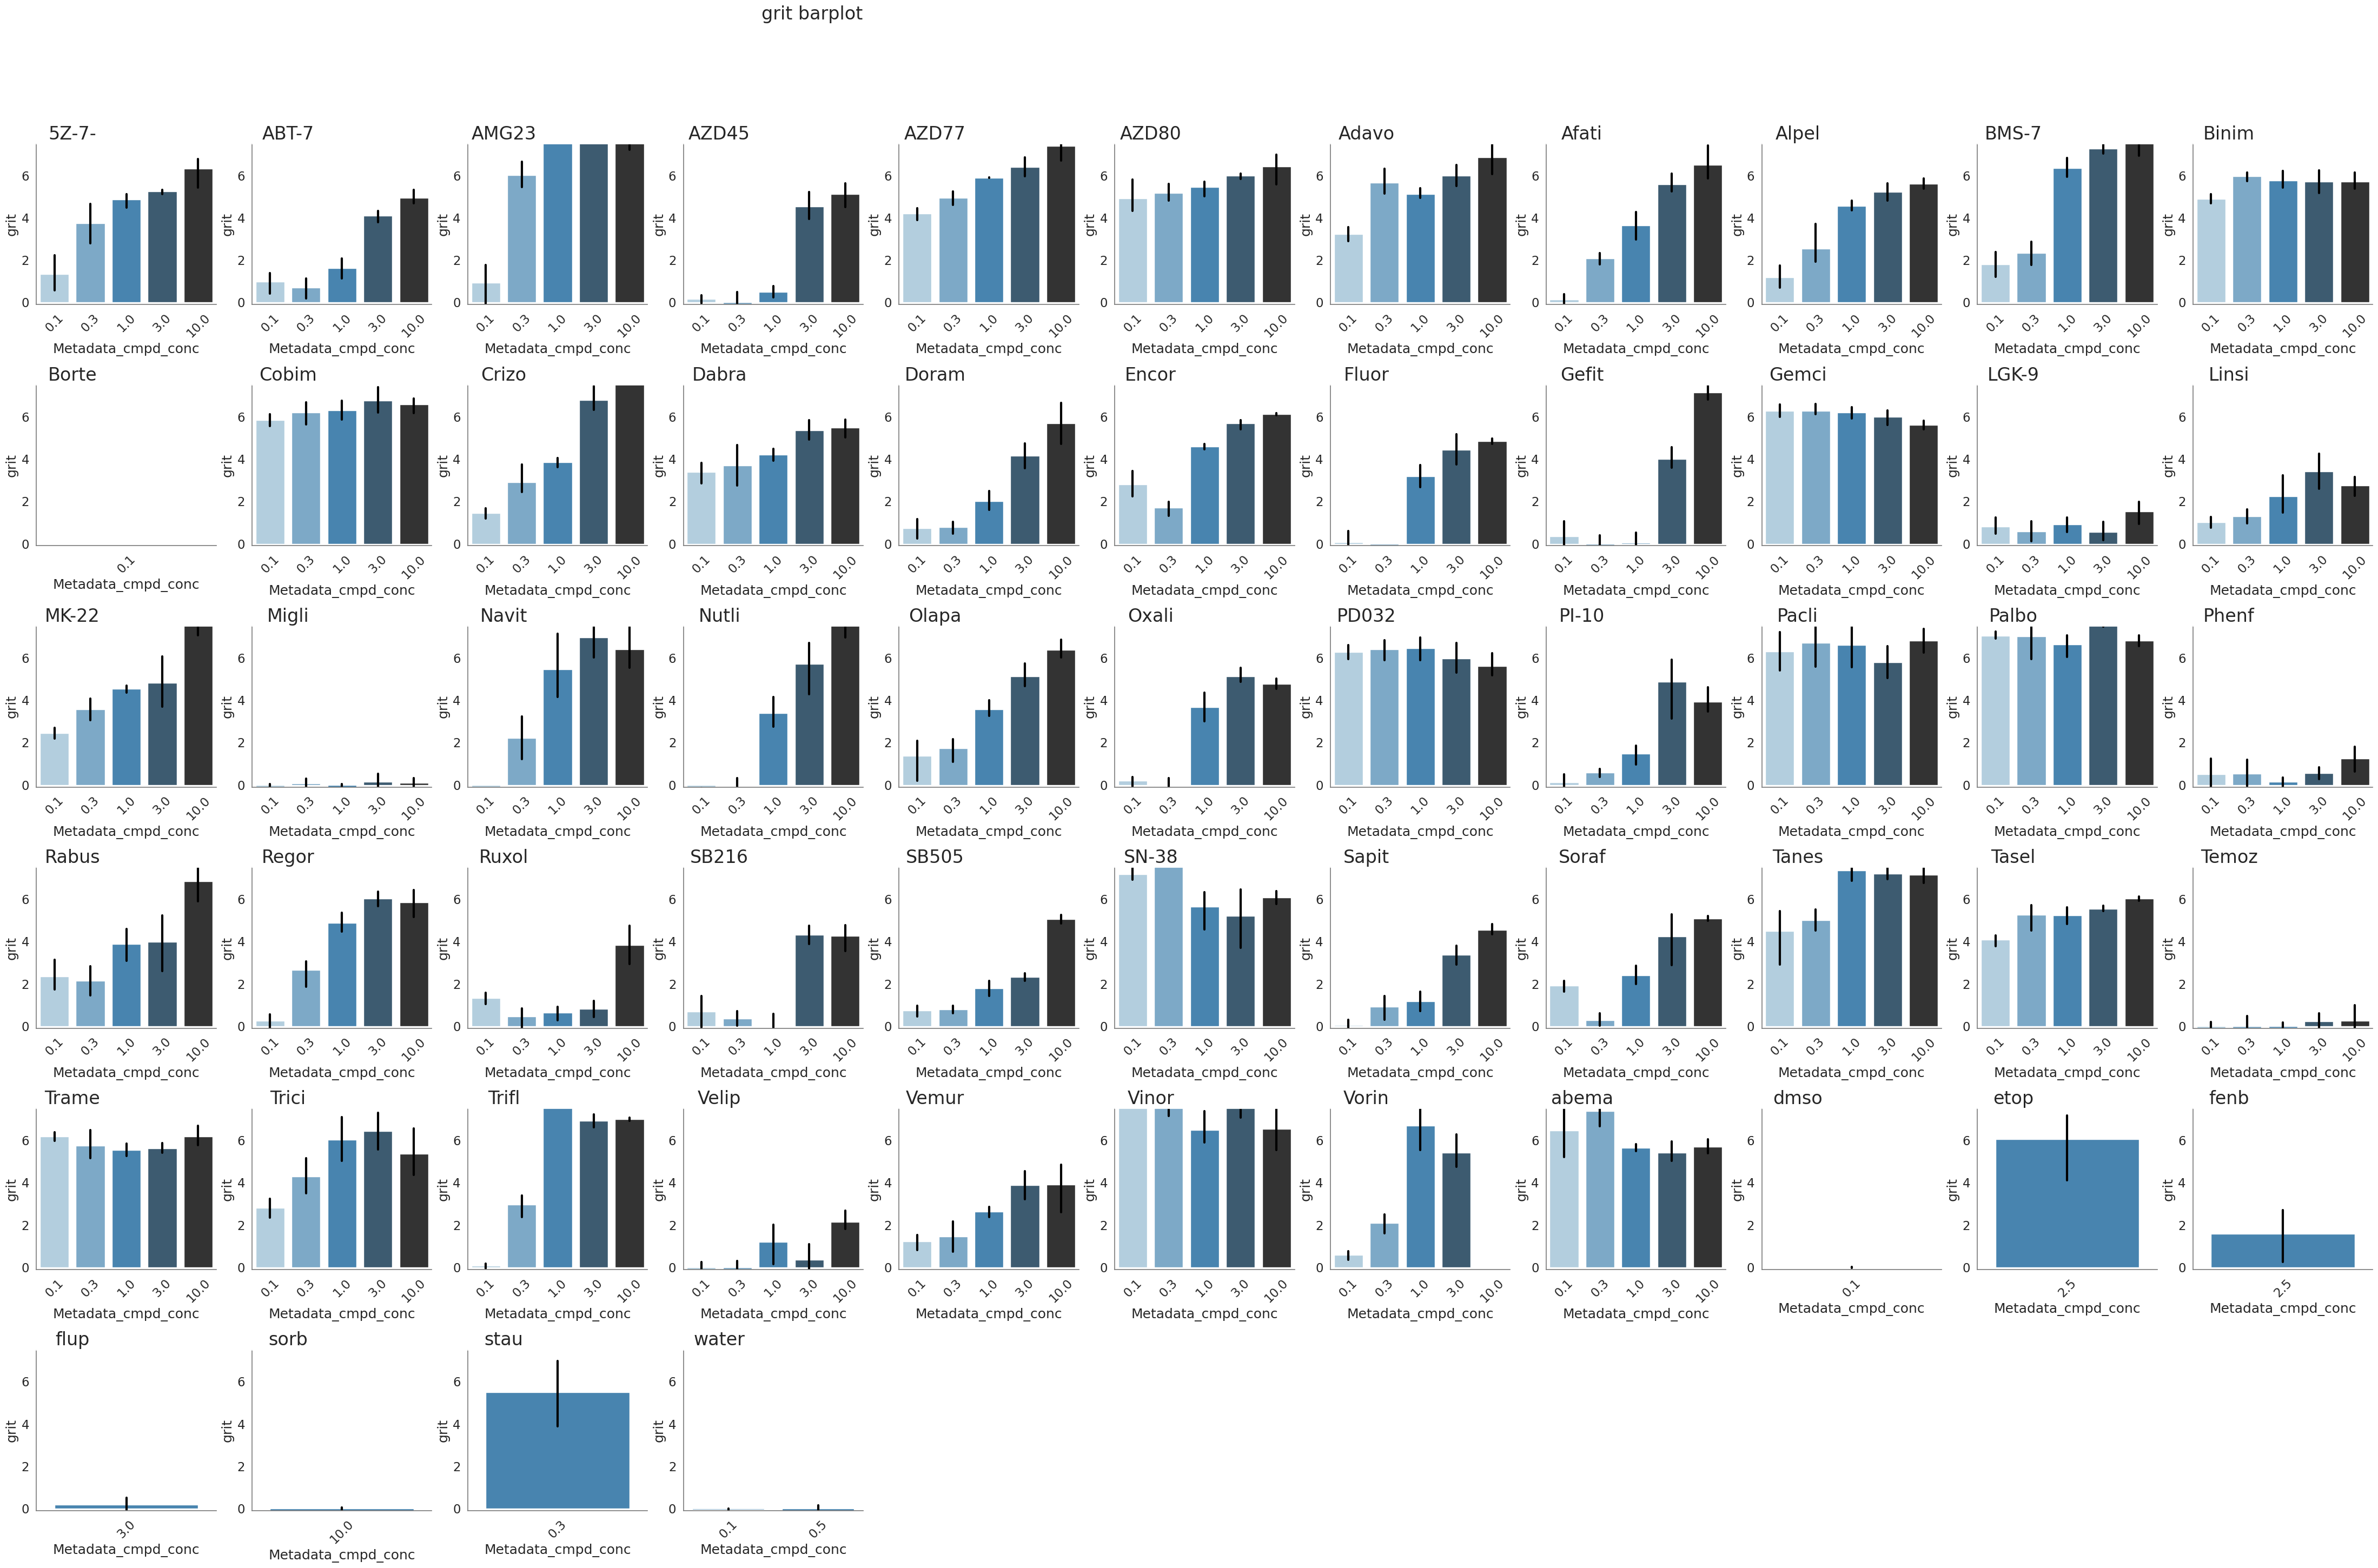

In [90]:
## Plot the grit dose response

# Plot the grit scores
fig = plt.figure(figsize=(48, 32))
sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 6
nrcol = 11
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 3,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_ylim([-0.1, 7.5])
    ax.set_title("{}".format(some), fontsize=24, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1
    
fig.savefig(
        "3_Figure3/3_GritScores/result-images/GritScores_{}.{}".format(cell_line,'png'), dpi=dpi, bbox_inches="tight"
        )

plt.show()


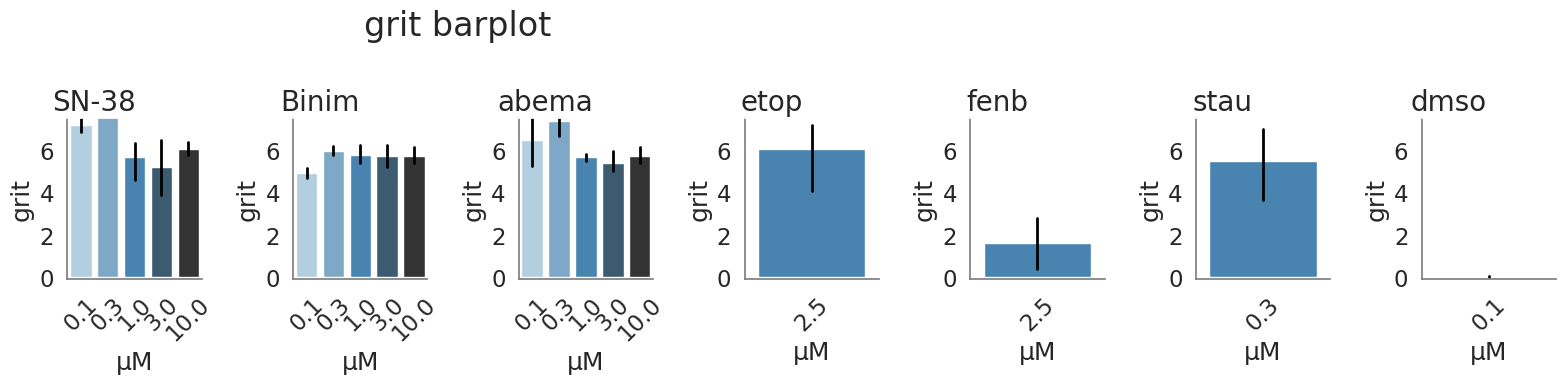

In [91]:
# Plot only a handful of compounds for the main figure

CompoundsUsed = ['SN-38', 'Binim', 'abema', 'etop','fenb','stau','dmso']


# Plot the grit scores
fig = plt.figure(figsize=(16, 4))
# sns.set(font_scale=1.5)
fig.suptitle("grit barplot ", fontsize=24, x=0.3)
sp = 1
nrrow = 1
nrcol = 7
for some in CompoundsUsed[:]:
    grit_scores_part = grit_scores[grit_scores["Metadata_name"] == some].copy()
    grit_scores_part.sort_values(by="Metadata_conc_step", inplace=True)
    ax = fig.add_subplot(nrrow, nrcol, sp)
    ax = sns.barplot(
        x="Metadata_cmpd_conc",
        y="grit",
        data=grit_scores_part,
        hue="Metadata_conc_step",
        legend=False,
        palette="Blues_d",
        alpha=1,
        err_kws={'linewidth': 2,'color': 'black'},
    )
    ax.set_facecolor("w")
    ax.spines["bottom"].set_color("grey")
    ax.spines["left"].set_color("grey")
    ax.set_yticks([0, 2, 4, 6])
    ax.set_ylim([-0.1, 7.5])
    ax.set_xlabel('µM')
    ax.set_title("{}".format(some), fontsize=20, x=0.2)
    plt.subplots_adjust(top=0.9, wspace=0.2, hspace=0.5, left=0.0)
    plt.xticks(rotation = 45)
    sp += 1

    fig.tight_layout()
    
fig.savefig(
        "3_Figure3/3_GritScores/result-images/GritScores_{}_{}.{}".format(cell_line, data_type, figformat), dpi=dpi, bbox_inches="tight"
        )

plt.show()

#### Add gritscores to the dataset for further processing

In [92]:
dataset_grit['Metadata_grit'] = grit_scores.grit.values

# Save as parquet
dataset_grit.to_parquet(('{}grit_data_{}_{}.parquet').format(dir, data_type, cell_line))

#### Return a few statistics

In [93]:
##
## Stats
##

# Count the number of consensus grit scores above 1.96
average = grit_scores.query("Metadata_pert_type == 'trt'").groupby(['Metadata_name', 'Metadata_conc_step']).grit.median().sort_values(ascending=False)

# Find where the value is above 1.96 and return the Metadata_name
print(data_type + " " + cell_line)
print("Grit scores more than 1.96: " + str(average[average > 1.96].index.get_level_values(0).nunique()))
print(average[average > 1.96].index.get_level_values(0).unique())
print("Out of: " + str(average.index.get_level_values(0).nunique()))

print(grit_scores.query("Metadata_pert_type == 'trt'").grit.describe())

2D HCT116
Grit scores more than 1.96: 46
Index(['SN-38', 'Crizo', 'MK-22', 'AMG23', 'Vinor', 'Palbo', 'Trifl', 'Nutli',
       'BMS-7', 'Navit', 'abema', 'Tanes', 'AZD77', 'Adavo', 'Gefit', 'Pacli',
       '5Z-7-', 'Cobim', 'AZD80', 'Rabus', 'PD032', 'Trici', 'Vorin', 'Gemci',
       'Afati', 'Olapa', 'Trame', 'Encor', 'Tasel', 'Regor', 'Binim', 'PI-10',
       'Doram', 'Alpel', 'Dabra', 'AZD45', 'Soraf', 'Oxali', 'SB505', 'Fluor',
       'ABT-7', 'SB216', 'Sapit', 'Vemur', 'Ruxol', 'Linsi'],
      dtype='object', name='Metadata_name')
Out of: 52
count    1002.000000
mean        3.902616
std         2.647890
min        -1.831079
25%         1.418492
50%         4.497979
75%         5.998181
max         9.819972
Name: grit, dtype: float64
